#### Első házi feladat
#### Gárdi Réka Lorin (ZRAF2X)
###### 2026. 03. 28.

In [1]:
# library-k betöltése
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from typing import Dict, List, Union
from scipy.stats import norm

**HW 2/1**: <br>
Smart up our plotter to be able to customize the hard-coded layout setup inside the function. Add more custom feature that you would like to use.

In [2]:
def my_plotter_enhanced(x: List[float], y: Union[List[float], List[List[float]]], layout: Dict = {}, names: List[str] = None,
                        line_styles: List[str] = None):
    
    y = [y] if all(isinstance(item, float) for item in y) else y

    # ha a felhasználó nem ad meg semmit, ezek az alapbeállítások
    default_layout = {
        'figsize': (8, 4),
        'title': None,
        'x_label': None,
        'y_label': None,
        'grid': True,
        'grid_style': '--',
        'x_lim': None,
        'y_lim': None,
        'tick_size': 12,
        'legend_fontsize': 14,
        'title_fontsize': 20,
        'label_fontsize': 16,
    }
    
    if layout is None:
        layout = {}
    plot_config = {**default_layout, **layout} # a felhasználó által megadott beállítások alkalmazásra kerülnek, a maradék
    #beállítás a default-ból jön

    plt.figure(figsize=plot_config['figsize'])
    lines = []
    
    show_legend = names is not None
    if names and len(names) != len(y):
        raise ValueError("Length of names is not matching with number of plotted y lists.")
    
    if line_styles and len(line_styles) != len(y):
        raise ValueError("Length of line styles is not matching with number of plotted y lists.")

    default_styles = ['solid', 'dashed', 'dashdot', 'dotted']
    line_styles = line_styles if line_styles else [default_styles[i % 4] for i in range(len(y))]

    for i, y_item in enumerate(y):
        plot_kwargs = {
            'linestyle': line_styles[i],
            'linewidth': 2,
            'label': names[i] if show_legend else None
        }
        _line = plt.plot(x, y_item, **plot_kwargs)
        lines.append(_line) 

    if show_legend:
        plt.legend(fontsize=plot_config['legend_fontsize'])

    if plot_config['title']:
        plt.title(plot_config['title'], fontsize=plot_config['title_fontsize'], pad=20)

    if plot_config['x_label']:
        plt.xlabel(plot_config['x_label'], fontsize=plot_config['label_fontsize'], labelpad=15)

    if plot_config['y_label']:
        plt.ylabel(plot_config['y_label'], fontsize=plot_config['label_fontsize'], labelpad=15)

    if plot_config['x_lim']:
        plt.xlim(plot_config['x_lim'])

    if plot_config['y_lim']:
        plt.ylim(plot_config['y_lim'])

    if plot_config['grid']:
        plt.grid(True, linestyle=plot_config['grid_style'])

    plt.xticks(fontsize=plot_config['tick_size'])
    plt.yticks(fontsize=plot_config['tick_size'])
    
    ax = plt.gca()
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    plt.show()

# az órai plotter-hez képest itt állítható a vonalak stílusa és vastagsága, személyre szabható a betűméret,
#továbbá további beállítások is elérhetők, például a grid, a tengelyek határainak beállítása

**HW 2/2**: <br>
Upgrade the BSM call option pricer to be able to return the greeks as well, not just the price.

In [3]:
def black_scholes_eur_call(r: Union[float, List[float]], T: Union[float, List[float]], S0: Union[float, List[float]], sigma: Union[float, List[float]], K: Union[float, List[float]], greeks: bool = False
):

    if np.isscalar(sigma):
        if sigma < 0:
            raise ValueError("Sigma must be non-negative.")
    else:
        if np.any(sigma < 0):
            raise ValueError("All elements in sigma must be non-negative.")

    K = np.array([K]) if np.isscalar(K) else np.array(K)
    S0 = np.array([S0]) if np.isscalar(S0) else np.array(S0)
    sigma = np.array([sigma]) if np.isscalar(sigma) else np.array(sigma)
    T = np.array([T]) if np.isscalar(T) else np.array(T)
    r = np.array([r]) if np.isscalar(r) else np.array(r)

    d1_vec = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2_vec = d1_vec - sigma * np.sqrt(T)

    N_d1_vec = norm.cdf(d1_vec)
    N_d2_vec = norm.cdf(d2_vec)
    
    call_price = N_d1_vec * S0 - K * np.exp(-r * T) * N_d2_vec
    price = call_price.item() if call_price.size == 1 else call_price

    if not greeks:
        return price

    pdf_d1 = norm.pdf(d1_vec)
    delta = N_d1_vec
    gamma = pdf_d1 / (S0 * sigma * np.sqrt(T))
    vega = S0 * pdf_d1 * np.sqrt(T)
    theta = (-S0 * pdf_d1 * sigma / (2 * np.sqrt(T))) - r * K * np.exp(-r * T) * N_d2_vec
    rho = K * T * np.exp(-r * T) * N_d2_vec

    greeks_dict = {
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega / 100,  # %-os változás
        "Theta": theta / 365,  # napra vetíte
        "Rho": rho / 100  # %-os változás
    }
    
    greeks_dict = {key: value.item() if value.size == 1 else value for key, value in greeks_dict.items()}

    return price, greeks_dict


In [4]:
K = 50
r = 0.05
T = 2
S0 = 40
sigma = 0.4

price, greeks = black_scholes_eur_call(r, T, S0, sigma, K, greeks=True)
print("Call Option ár:", price)
print("Greeks:", greeks)


Call Option ár: 7.088620247390349
Greeks: {'Delta': 0.5259741525618467, 'Gamma': 0.017593542594486457, 'Vega': 0.22519734520942666, 'Theta': -0.00808079656122861, 'Rho': 0.2790069171016703}


**HW 2/3**: <br>
Implement the BSM pricer for European put option.

In [5]:
"""The pricing function of European put option"""
def black_scholes_eur_put(r: Union[float, List[float]], T: Union[float, List[float]], S0: Union[float, List[float]], sigma: float, K: Union[float, List[float]]):
    """
    Black-Scholes pricer of European put option on non-dividend-paying stock

    param r: risk-free interest rate (which is constant)
    param T: time to maturity (in years)
    param S0: initial spot price of the underlying stock
    param sigma: volatility of the underlying stock
    param K: strike price (or prices)
    """
    # check conditions
    if np.isscalar(sigma):
        if sigma < 0:
            raise ValueError("Sigma must be non-negative.")
    else:
        if np.any(sigma < 0):
            raise ValueError("All elements in sigma must be non-negative.")


    K = np.array([K]) if np.isscalar(K) else np.array(K)
    S0 = np.array([S0]) if np.isscalar(S0) else np.array(S0)
    sigma = np.array([sigma]) if np.isscalar(sigma) else np.array(sigma)
    T = np.array([T]) if np.isscalar(T) else np.array(T)
    r = np.array([r]) if np.isscalar(r) else np.array(r)

    d1_vec = ( np.log( S0 / K ) + ( r + 0.5 * sigma**2 ) * T ) / ( sigma * T**0.5 )
    d2_vec = d1_vec - sigma * T**0.5

    neg_N_d1_vec = norm.cdf(-1.0*d1_vec)
    neg_N_d2_vec = norm.cdf(-1.0*d2_vec)

    return neg_N_d2_vec *  K * np.exp((-1.0)*r*T) - neg_N_d1_vec * S0

**HW 2/4**: <br>
With the call and put pricer, check if Put-Call parity holds in practice.

A put-call paritás azt mondja, hogy egy azonos kötési árfolyammal és lejárattal rendelkező long call és short put értéke egybeesik egy azonos paraméterekkel rendelkező long forward értékével.

In [6]:
# különböző K-k

K = np.arange(10,100,0.01)
r = 0.05
T = 2
S0 = 40
sigma = 0.4

parity = np.round((black_scholes_eur_call(r, T, S0, sigma, K) - black_scholes_eur_put(r, T, S0, sigma, K)),8) == np.round((S0 - K * np.exp((-1.0)*r*T)),8)

#szükség van a kerekítésre, különben numerikus közelítési hiba miatt nem mondja egyenlőnek a két értéket a kód

np.unique(parity, return_counts=True)
#csak True értékek

(array([ True]), array([9000], dtype=int64))

In [7]:
# különböző r-k

K = 20
r = np.arange(0.01,1,0.001)
T = 2
S0 = 40
sigma = 0.4

parity = np.round((black_scholes_eur_call(r, T, S0, sigma, K) - black_scholes_eur_put(r, T, S0, sigma, K)),8) == np.round((S0 - K * np.exp((-1.0)*r*T)),8)
np.unique(parity, return_counts=True)
#csak True értékek

(array([ True]), array([990], dtype=int64))

In [8]:
# különböző T-k

K = 20
r = 0.05
T = np.arange(1,100,1)
S0 = 40
sigma = 0.4

parity = np.round((black_scholes_eur_call(r, T, S0, sigma, K) - black_scholes_eur_put(r, T, S0, sigma, K)),8) == np.round((S0 - K * np.exp((-1.0)*r*T)),8)
np.unique(parity, return_counts=True)
#csak True értékek

(array([ True]), array([99], dtype=int64))

In [10]:
# különböző S0-k

K = 20
r = 0.05
T = 2
S0 = np.arange(10,200,0.5)
sigma = 0.4

parity = np.round((black_scholes_eur_call(r, T, S0, sigma, K) - black_scholes_eur_put(r, T, S0, sigma, K)),8) == np.round((S0 - K * np.exp((-1.0)*r*T)),8)
np.unique(parity, return_counts=True)
#csak True értékek

(array([ True]), array([380], dtype=int64))

In [9]:
# különböző sigma-k

K = 20
r = 0.05
T = 2
S0 = 40
sigma = np.arange(0.01,1,0.01)

parity = np.round((black_scholes_eur_call(r, T, S0, sigma, K) - black_scholes_eur_put(r, T, S0, sigma, K)),8) == np.round((S0 - K * np.exp((-1.0)*r*T)),8)
np.unique(parity, return_counts=True)
#csak True értékek

(array([ True]), array([99], dtype=int64))

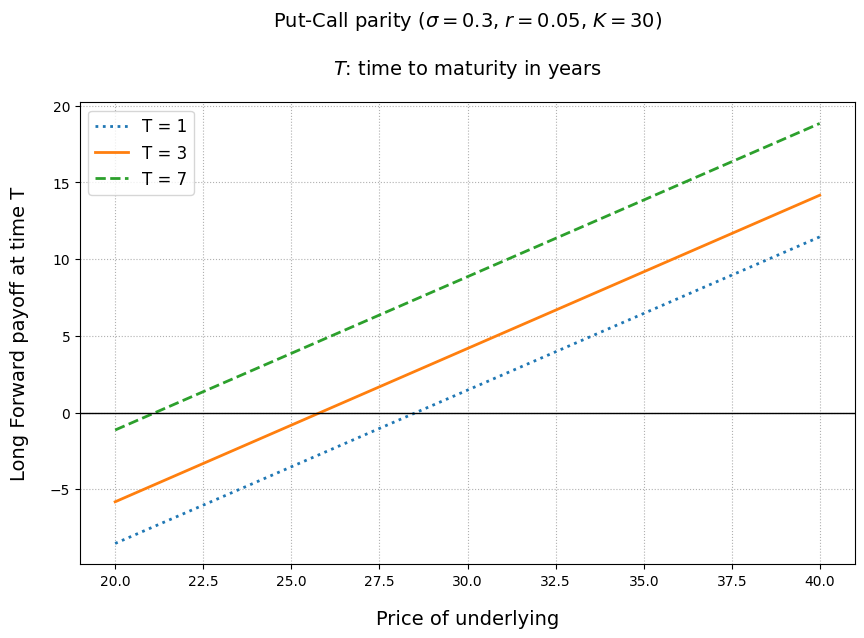

In [11]:
S_vec = np.arange(20, 40, 0.01)
T_vec = [1.0, 3.0, 7.0]

prices_to_plot = []
for _T in T_vec:
    prices_to_plot.append(
        black_scholes_eur_call(r = 0.05, T = _T, S0 = S_vec , sigma = 0.3, K = 30) - black_scholes_eur_put(r = 0.05, T = _T, S0 = S_vec , sigma = 0.3, K = 30)
    )

layout = {
    'figsize': (10, 6),
    'title':'Put-Call parity ($\sigma = 0.3$, $r = 0.05$, $K = 30$)\n\n$T$: time to maturity in years',
    'x_label': 'Price of underlying',
    'y_label': 'Long Forward payoff at time T',
    'grid': True,
    'grid_style': ':',
    'tick_size': 10,
    'legend_fontsize': 12,
    'title_fontsize': 14,
    'label_fontsize': 14,
}  

vonalak = ['dotted', 'solid', 'dashed']

my_plotter_enhanced(S_vec, prices_to_plot, layout=layout, names=[f'T = {int(item)}' for item in T_vec], line_styles = vonalak)

#T időpontbeli long forward kifizetések láthatók az ábrán a put-call paritás segítségével ábrázolva